# Basic Manual RNN

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [2]:
# Number of inputs for each example
num_inputs = 2

# Number of neurons in first layer
num_neurons = 3

## Placeholders

In [3]:
# We now need two Xs! One for each timestamp (t=0 and t=1)
x0 = tf.placeholder(tf.float32,[None,num_inputs])
x1 = tf.placeholder(tf.float32,[None,num_inputs])

## Variables

In [4]:
# We'll also need a Weights variable for each x
# Notice the shape dimensions on both!
Wx = tf.Variable(tf.random_normal(shape=[num_inputs,num_neurons]))
Wy = tf.Variable(tf.random_normal(shape=[num_neurons,num_neurons]))
b = tf.Variable(tf.zeros([1,num_neurons]))

## Graphs

In [5]:
# First Activation
y0 = tf.tanh(tf.matmul(x0,Wx) + b)
y1 = tf.tanh(tf.matmul(y0,Wy) + tf.matmul(x1,Wx) + b)

## Initialize Variables

In [6]:
init = tf.global_variables_initializer()

## Run Session

In [7]:
# BATCH 0:       example1 , example2, example 3
x0_batch = np.array(
    [[0,1],  [2,3],    [4,5]]) # DATA AT TIMESTAMP = 0
# BATCH 0:          example1 ,   example2,   example 3
x1_batch = np.array(
    [[100,101], [102,103],  [104,105]]) # DATA AT TIMESTAMP = 1
with tf.Session() as sess:
    sess.run(init)
    y0_output_vals , y1_output_vals  = sess.run(
        [y0,y1],feed_dict={x0:x0_batch,x1:x1_batch})

In [8]:
# The output of values at t=0
y0_output_vals

array([[-0.73476195,  0.92810434, -0.21905078],
       [-0.99071479,  1.        ,  0.84975833],
       [-0.99971545,  1.        ,  0.99158311]], dtype=float32)

In [9]:
# Output at t=1
y1_output_vals

array([[-1.,  1.,  1.],
       [-1.,  1.,  1.],
       [-1.,  1.,  1.]], dtype=float32)

# RNN with TensorFlow API

## The Data

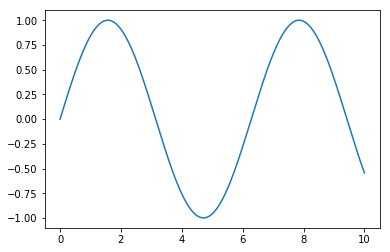

In [10]:
class TimeSeriesData():
    def __init__(self,num_points,xmin,xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(
        self,batch_size,steps,return_batch_ts=False):
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1) 
        # Convert to be on time series
        ts_start = rand_start * (
            self.xmax- self.xmin - (steps*self.resolution) )
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(
                -1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        else:
            return y_batch[:, :-1].reshape(
                -1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        
ts_data = TimeSeriesData(250,0,10)
plt.plot(ts_data.x_data,ts_data.y_true)

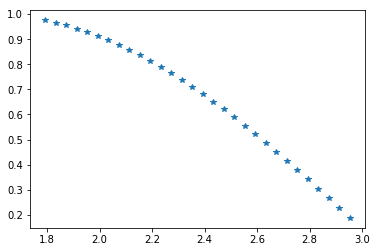

In [11]:
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 30
y1,y2,ts = ts_data.next_batch(1,num_time_steps,True)
plt.plot(ts.flatten()[1:],y2.flatten(),'*')

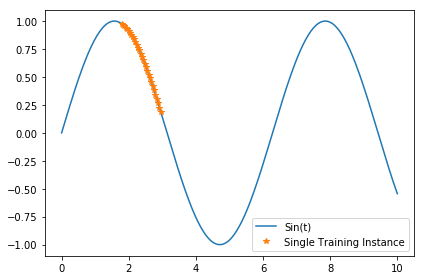

In [12]:
plt.plot(ts_data.x_data,ts_data.y_true,label='Sin(t)')
plt.plot(ts.flatten()[1:],y2.flatten(),'*',label='Single Training Instance')
plt.legend()
plt.tight_layout()

## Training Instance and what to Predict

We are trying to predict a time series shifted over by t+1

In [13]:
train_inst = np.linspace(5,5 + ts_data.resolution * 
                         (num_time_steps + 1), num_time_steps+1)

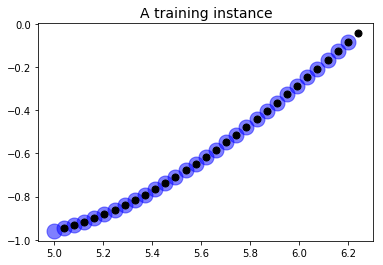

In [14]:
plt.title("A training instance", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(
    train_inst[:-1]), "bo", markersize=15,alpha=0.5 ,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(
    train_inst[1:]), "ko", markersize=7, label="target")

## Creating the model

### Constants

In [15]:
tf.reset_default_graph()
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, 
#but you can play with this
learning_rate = 0.0001
# how many iterations to go through 
#(training steps), you can play with this
num_train_iterations = 2000
# Size of the batch of data
batch_size = 1

### Placeholders

In [16]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

____
____
### RNN Cell Layer

Play around with the various cells in this section, compare how they perform against each other.

In [17]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)
"""
cell = tf.contrib.rnn.OutputProjectionWrapper(
     tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
     output_size=num_outputs)    

n_neurons = 100
n_layers = 3

cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
           for layer in range(n_layers)])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

n_neurons = 100
n_layers = 3

cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
           for layer in range(n_layers)])
"""


'\ncell = tf.contrib.rnn.OutputProjectionWrapper(\n     tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),\n     output_size=num_outputs)    \n\nn_neurons = 100\nn_layers = 3\n\ncell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)\n           for layer in range(n_layers)])\n\ncell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)\n\nn_neurons = 100\nn_layers = 3\n\ncell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)\n           for layer in range(n_layers)])\n'

_____
_____

### Dynamic RNN Cell

In [18]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss function and Optimizer

In [19]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

### Init Variables

In [20]:
init = tf.global_variables_initializer()

## Session

In [21]:
# ONLY FOR GPU USERS:
# https://stackoverflow.com/questions/34199233/
# how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
saver = tf.train.Saver()
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 0.169254
100 	MSE: 0.100234
200 	MSE: 0.0442132
300 	MSE: 0.00473804
400 	MSE: 0.0102347
500 	MSE: 0.0262023
600 	MSE: 0.0220417
700 	MSE: 0.0182428
800 	MSE: 0.023012
900 	MSE: 0.0187102
1000 	MSE: 0.00861806
1100 	MSE: 0.0127849
1200 	MSE: 0.00182524
1300 	MSE: 0.0183326
1400 	MSE: 0.00977377
1500 	MSE: 0.00130536
1600 	MSE: 0.000287171
1700 	MSE: 0.000603855
1800 	MSE: 0.00241661
1900 	MSE: 0.0084391


### Predicting a time series t+1

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


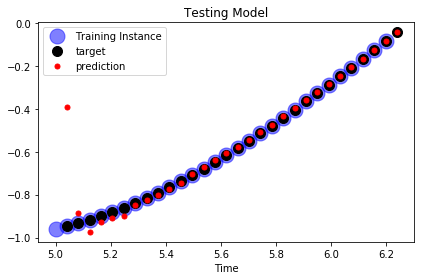

In [22]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
plt.title("Testing Model")
# Training Instance
plt.plot(train_inst[:-1], np.sin(
    train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")
# Target to Predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")
# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()

## Generating New Sequences

Sometimes can give interesting and wacky results, tread carefully

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


Text(0,0.5,'Value')

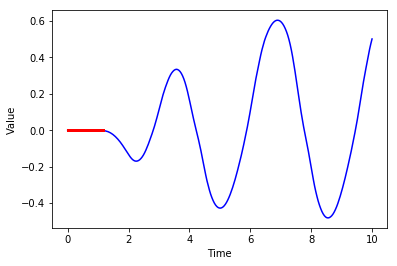

In [23]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")
    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(
            zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])
        
plt.plot(ts_data.x_data, zero_seq_seed, "b-")
plt.plot(ts_data.x_data[:num_time_steps], 
         zero_seq_seed[:num_time_steps], "r", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


Text(0.5,0,'Time')

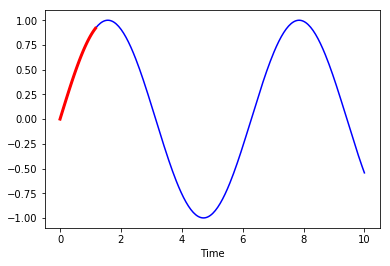

In [26]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")
    # SEED WITH Training Instance
    training_instance = list(ts_data.y_true[:30])
    for iteration in range(len(training_instance) -num_time_steps):
        X_batch = np.array(
            training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])
        
plt.plot(ts_data.x_data, ts_data.y_true, "b-")
plt.plot(ts_data.x_data[:num_time_steps],
         training_instance[:num_time_steps], "r-", linewidth=3)
plt.xlabel("Time")

# Time Series Exercise

## The Data

Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line

Monthly milk production: pounds per cow. Jan 62 - Dec 75

1\. Import numpy pandas and matplotlib

2\. Use pandas to read the csv of the monthly-milk-production.csv file and set index_col='Month'

3\. Check out the head of the dataframe

4\. Make the index a time series by using:
    
        milk.index = pd.to_datetime(milk.index)
        
5\. Plot out the time series data.

___

### Train Test Split

6\. Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future)

7\. Create a test train split using indexing (hint: use .head() or tail() or .iloc[]). We don't want a random train test split, we want to specify that the test set is the last 3 months of data is the test set, with everything before it is the training.

### Scale the Data

8\. Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!

### Batch Function

9\. We'll need a function that can feed batches of the training data. We'll need to do several things that are listed out as steps in the comments of the function. Remember to reference the previous batch method from the lecture for hints. Try to fill out the function template below, this is a pretty hard step, so feel free to reference the solutions!

## Setting Up The RNN Model

10\. Import TensorFlow

### The Constants

11\. Define the constants in a single cell. You'll need the following (in parenthesis are the values I used in my solution, but you can play with some of these): 
* Number of Inputs (1)
* Number of Time Steps (12)
* Number of Neurons per Layer (100)
* Number of Outputs (1)
* Learning Rate (0.003)
* Number of Iterations for Training (4000)
* Batch Size (1)

12\. Create Placeholders for X and y. (You can change the variable names if you want). The shape for these placeholders should be [None,num_time_steps-1,num_inputs] and [None, num_time_steps-1, num_outputs] The reason we use num_time_steps-1 is because each of these will be one step shorter than the original time steps size, because we are training the RNN network to predict one point into the future based on the input sequence.

13\. Now create the RNN Layer, you have complete freedom over this, use tf.contrib.rnn and choose anything you want, OutputProjectionWrappers, BasicRNNCells, BasicLSTMCells, MultiRNNCell, GRUCell etc... Keep in mind not every combination will work well! (If in doubt, the solutions used an Outputprojection Wrapper around a basic LSTM cell with relu activation.

14\. Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)

### Loss Function and Optimizer

15\. Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, remember to pass in your learning rate.

16\. Initialize the global variables

17\. Create an instance of tf.train.Saver()

### Session

18\. Run a tf.Session that trains on the batches created by your next_batch function. Also add an a loss evaluation for every 100 training iterations. Remember to save your model after you are done training. 

## Predicting Future (Test Data)

19\. Show the test_set (the last 12 months of your original complete data set)

### Generative Session

Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our generated 12 months to our actual true historical values from the test set!

NOTE: Recall that our model is really only trained to predict 1 time step ahead, asking it to generate 12 steps is a big ask, and technically not what it was trained to do! Think of this more as generating new values based off some previous pattern, rather than trying to directly predict the future. You would need to go back to the original model and train the model to predict 12 time steps ahead to really get a higher accuracy on the test data. (Which has its limits due to the smaller size of our data set)

20\. Fill out the session code below to generate 12 months of data based off the last 12 months of data from the training set. The hardest part about this is adjusting the arrays with their shapes and sizes. Reference the lecture for hints.

21\. Show the result of the predictions.

21\. Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.

22\. Create a new column on the test_set called "Generated" and set it equal to the generated results. You may get a warning about this, feel free to ignore it.

23\. View the test_set dataframe.

24\. Plot out the two columns for comparison.

Play around with the parameters and RNN layers, does a faster learning rate with more steps improve the model? What about GRU or BasicRNN units? What if you train the original model to not just predict one timestep ahead into the future, but 3 instead? Lots of stuff to add on here!

# Word2Vec tutorial

## Imports

In [24]:
import collections
import math
import os
import errno
import random
import zipfile
import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf

## The Data

In [25]:
data_dir = "word2vec_data/words"
data_url = 'http://mattmahoney.net/dc/text8.zip'

def fetch_words_data(url=data_url, words_data=data_dir):
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

# Use Defaults (this make take awhile!!)
words = fetch_words_data()
# Random slice of words
for w in words[9000:9014]:
    print(w,end=' ')

feelings and the auditory system of a person without autism often cannot sense the 

## Building Word Counts

In [26]:
from collections import Counter
mylist = ["one",'one','two']
Counter(mylist).most_common(1)

[('one', 2)]

## Create Word Data and Vocabulary

In [27]:
def create_counts(vocab_size=50000):
    # Begin adding vocab counts with Counter
    vocab = [] + Counter(words).most_common(vocab_size )
    # Turn into a numpy array
    vocab = np.array([word for word, _ in vocab])
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data,vocab
vocab_size = 50000
# This may take awhile
data,vocabulary = create_counts(vocab_size=vocab_size)

In [28]:
(words[100],data[100])

('interpretations', 4186)

## Function for Batches

In [29]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels
data_index=0
batch, labels = generate_batch(8, 2, 1)

## Constants

In [30]:
# Size of the bath
batch_size = 128

# Dimension of embedding vector
embedding_size = 150

# How many words to consider left and right (the bigger, the longer the training)
skip_window = 1       

# How many times to reuse an input to generate a label
num_skips = 2      

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.

# Random set of words to evaluate similarity on.
valid_size = 16   

# Only pick dev samples in the head of the distribution.
valid_window = 100  
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Number of negative examples to sample.
num_sampled = 64   

# Model Learning Rate
learning_rate = 0.01

# How many words in vocab
vocabulary_size = 50000

## TensorFlow Placeholders and Constants

In [31]:
tf.reset_default_graph()
# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

## Variables

In [32]:
# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

## NCE Loss

In [33]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal(
        [vocabulary_size, embedding_size],stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

## Optimizer

In [34]:
# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
# Add variable initializer.
init = tf.global_variables_initializer()

## Session

In [35]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [ ]:
# Usually needs to be quite large to get good results, 
# training takes a long time!
num_steps = 200001
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):       
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}
        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        if step % 20000 == 0:
            if step > 0:
                average_loss /= 20000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  317.766845703
Average loss at step  20000 :  39455.5291396
Average loss at step  40000 :  54623.6779175
Average loss at step  60000 :  66518.9150379
Average loss at step  80000 :  70374.9083885


## Visualizing Results

In [ ]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

### TSNE

* https://lvdmaaten.github.io/tsne/
* https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

Dimensionality reduction to 2-D vectors (down from 150), this takes awhile.

In [ ]:
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 2000
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

In [ ]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10,10)
plt.ylim(-10,10)

### Also check out gensim!

https://radimrehurek.com/gensim/tutorial.html

https://stackoverflow.com/questions/40074412/word2vec-get-nearest-words

In [ ]:
np.save('trained_embeddings_200k_steps',final_embeddings)